In [62]:
# Useful Functions 

def testplot(x,y,x_label, y_label, plt_title, xlim, ylim):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=x_label, ylabel=y_label, title=plt_title)
    if xlim != 0:
        plt.xlim(xlim)
    if ylim != 0:
        plt.ylim(ylim)
    ax.grid()
    plt.show()
    

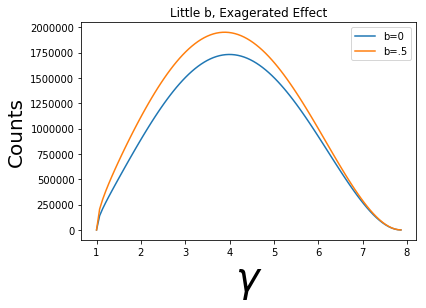

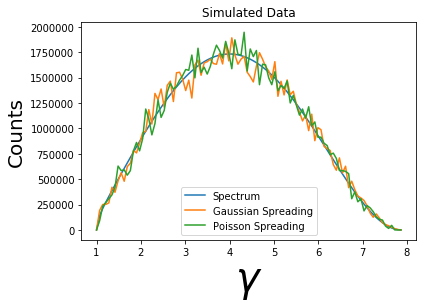

In [48]:
# Cell showing that the spectrum construction is working. 


%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt


# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#

N = 1e8  # number of counts (simulated).
n1 = 1  # normalization constant for fit
n2 = .5  # normalization constant for fit
n_x = 100  # number of energy bins

# ---------------------------------------------------------#


def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in eV


x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers

f_st = spect_data(x, e0)  # standard spectrum
sum1 = sum(f_st)  # using the sum of the list to normalize.
f_st = f_st * N / sum1 
y_fit = n1*f_st + n2*f_st/x  # lil_b effected spectrum
sum2 = sum(y_fit)  # using the sum of the list to normalize. 

y_gdata = np.around(N/sum1*np.random.normal(spect_data(x, e0), spect_data(x, e0) ** .5))  # Normalizing and rounding (gaussian)
y_pdata = np.around(N/sum1*np.random.poisson(spect_data(x, e0)))  # Normalizing and rounding (poisson)


plt.plot(x, f_st, x, y_fit)  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Little b, Exagerated Effect")
plt.gca().legend(('b=0', 'b=.5'))

plt.show()

plt.plot(x, f_st, x, y_gdata, x, y_pdata)  # Plotting the simulated data
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Simulated Data")
plt.gca().legend(('Spectrum', 'Gaussian Spreading', 'Poisson Spreading'))

plt.show()


7.864970645792564
this should be exactly N -> 10000000000.000017
percentage of P that is nan: 0.0


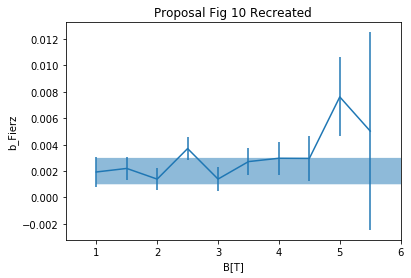

In [49]:
# Here I am parsing the data by field and redoing Alejandro's Fig. 10 in our proposal.
# Note that NR denotes Numerical Recipes so that you can follow along with the math. 

%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import math


# -------------------Physical (or natural) Constants -------------------#

me = 5.11e5  # electron mass in eV/c^2
c = 3*10**8
pi= math.pi


# --------------------Input Parameters--------------------#

N = 1e10    # number of counts (simulated).
lil_b = 2e-3 # little b value
n_x = 1000  # number of energy bins in entire spectrum 
n_M = 2    # number of fit parameters 


# -----------------Constructing the Standard (b=0) beta spectrum-------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.
print(e0)

x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit(A,B):
    return A*f_st + B*f_st/x # This function is used to create fake data and to fit. lil_b = B/A. 


# --------------------Normalizing--------------------#

n1_init = 1000   # I use this to create an initital spectrum and then renormalize to get N total counts.  
norm = sum(y_fit(n1_init,lil_b*n1_init))  # norm is the total number of "counts" initially.

C_norm = n1_init*N/norm  # renormalization constant

n1 = C_norm   
n2 = lil_b*C_norm    


print('this should be exactly N ->', sum(y_fit(n1,n2))) # Verifying that the normalization worked. 



# ----------------Setting up the different arrays necessary for the fitting  ------------------------#

n_B = 10 # Sets number of different field strengths we will run with 

P = np.zeros(shape=(n_M,n_B)) # Fit parameters n1, n2 for each field configuration
P_unc = np.zeros(shape=(n_M,n_B)) # Fit uncertainies for each field configuration (NR 15.4.15)
b_fit = np.zeros(shape=(n_B))  # b (from n1, n2) for each field configuration
b_fit_unc = np.zeros(shape=(n_B)) # uncertainty in b for for each field configuration


# --------------------Faking Data --------------------#

y_gdata = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) # Gaussian random data. 


# --------------------Boundries in Energy for different fields and a fixed 18-24 Ghz bandwidth --------------------#

E_boundries_high = np.zeros(shape=(n_B))  # Upper/Lower bounds in energy for a given B field 
E_boundries_low = np.zeros(shape=(n_B))  

ftoE = c**2/(me*2*pi)  # Note that this is more aptly f to gamma b/c E is measured in units of m_e
B_start = 1 # B field starting at 1 T
B_inc = .5  # B field increased in units of .5 T
f_min = 18e9 # GHz
f_max = 24e9 # GHz


h = 0
while h < n_B:
    E_boundries_high[h] = ftoE*(B_start + h*B_inc)/f_min
    E_boundries_low[h] = ftoE*(B_start + h*B_inc)/f_max  
    h += 1 

    
E_boundries_high_indicies= np.rint((E_boundries_high - 1)*n_x/(e0-1)) # Indicies of the energy bounds
E_boundries_low_indicies= np.rint((E_boundries_low - 1)*n_x/(e0-1))   
# Note that there is overlap in energies between fields especially at higher fields

# There can be energies at these fields and bandwidth beyond our endpoint energy.
# Here I am changing those bounds to just be the last bin of our spectrum. 
g = 0 
while g< n_B: 
    if E_boundries_high_indicies[g] >= n_x:
        E_boundries_high_indicies[g] = n_x-1
    if E_boundries_low_indicies[g] >= n_x:
        E_boundries_low_indicies[g] = n_x-1
    g += 1


# --------------------General Linear Least Squares -> n1, n2 -> lil_b (for each field strength) --------------------#

j = 0 
while j < n_B: 
    
    # --------------------Parcing up the relevant arrays --------------------#
    x_temp = x[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    f_st_temp = f_st[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    y_gdata_temp = y_gdata[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    n_x_temp = len(x_temp)
    

    # --------------------Putting together the Toolbox: NR 15.4.1-3--------------------#

    X = np.array([f_st_temp,f_st_temp/x_temp]).transpose() # basis functions. 
    sigma = y_gdata_temp**.5  # Assuming gaussian random data
   

    # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
    A = np.zeros(shape=(n_x_temp,n_M))
    
    i=0
    while i < n_M:
        A[:,i] = X[:,i]/sigma
        i += 1
    
    b_matrix = y_gdata_temp/sigma
    alpha = A.transpose() @ A  #NR 15.5.8
    beta = A.transpose() @ b_matrix   #NR 15.5.9

    P[:,j] = np.linalg.inv(alpha) @ beta

    
    
    # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
    i=0
    while i < n_M:
        P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
        i += 1
    b_fit[j] = P[1,j]/P[0,j] # b = n2/n1
    
    # below is the uncertainty in b using error propigation with a non-zero covariance 
    b_fit_unc[j] = ((P[1,j]/P[0,j])**2 *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2) 
                    - 2*(P[1,j]/P[0,j]**3)*np.linalg.inv(alpha)[0,1])**.5 
    j += 1 

    
# --------------------Debugging to see if any of the fits failed --------------------#        

#This prints the number of nan pairs I get in my P matrix
print("percentage of P that is nan:",np.argwhere(np.isnan(P)).shape[0]/(2*n_B))

    
# --------------------Recreating Alejandro's Fig 10--------------------#   

B_spect = np.zeros(shape = n_B)  # Array for the x axis of the plot 
j = 0
while j < n_B:
    B_spect[j] = B_start + j*B_inc
    j += 1 
    

plt.figure()
plt.fill_between(x, .001, .003, alpha=0.5)
plt.xlim(.5,6)
plt.errorbar(B_spect, b_fit, b_fit_unc)
plt.title("Proposal Fig 10 Recreated")    
plt.ylabel('b_Fierz')
plt.xlabel('B[T]')
plt.show()   


# # -------------------- Plotting n1,n2 (histogram)  --------------------# 

# k = 0
# while k < n_M: 
#     plt.hist(P[k,:]*norm/(n1_init*N), bins=50)
#     plt.ylabel('Frequency')
#     plt.xlabel('Parameter n%d' % k)
#     plt.show()
#     k += 1 





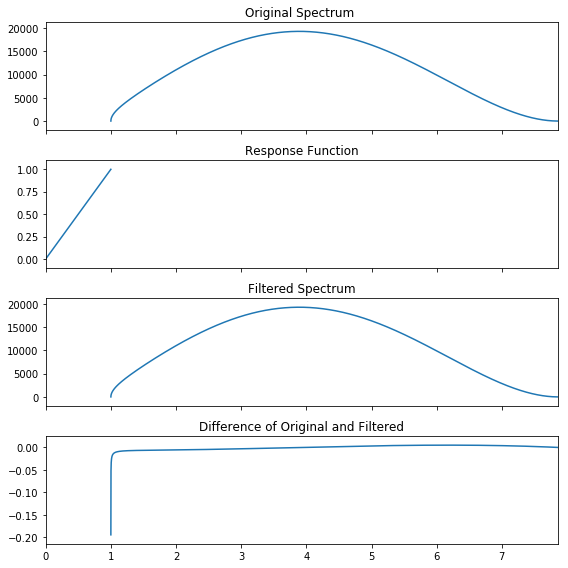

In [50]:
from scipy import special
from scipy import signal
import matplotlib.pyplot as plt


# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#

N = 1e8  # number of counts (simulated).
n1 = 1  # normalization constant for fit
n2 = .5  # normalization constant for fit
n_x = 10000  # number of energy bins
n_y = 10000
# ---------------------------------------------------------#


def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in eV


x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers
# Don't actually need this function now that I can use the 'valid' function. 
# def simple_tail(width,height,n_x) : 
#     tail = np.zeros(n_x)
#     center = int(np.around(n_x/2))
#     center = 10
#     tail[center] = 1 - height*width
#     tail[center-(width):center] = height
#     return tail  

# creating the little b effected spectrum
f_st = spect_data(x, e0)  # standard spectrum
sum1 = sum(f_st)  # using the sum of the list to normalize.
f_st = f_st * N / sum1 
y_fit = n1*f_st + n2*f_st/x  # lil_b effected spectrum
sum2 = sum(y_fit)  # using the sum of the list to normalize. 

# Creating the response function. 
frac = 10**-3
win = [frac,1-frac]  # sums to 1. 


def filt(function, window): 
    return signal.convolve( function, window, mode='valid')  / sum(window)  # Should think about why not to use 'full'

filtered = filt(y_fit, win) 

filtered = np.pad(filtered, (0,1), 'constant') # The covolution overlap has only n_x - 1 elements since 
# the window is two elements long. So you need to pad the filtered array with some zeros. 
difference = (y_fit-filtered)  # This is the relative difference of the two. Thus the division by the sum. 


# Note that you need to divide by the sum/integral of the signal you are convolving it with. 

fig, (ax_orig, ax_win, ax_filt, ax_difference) = plt.subplots(4, 1, sharex=True,figsize = (8,8))
ax_orig.plot(x,y_fit)
ax_orig.set_title('Original Spectrum ')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Response Function')
ax_win.margins(0, 0.1)
ax_filt.plot(x,filtered)
ax_filt.set_title('Filtered Spectrum')
ax_filt.margins(0, 0.1)
ax_difference.plot(x,difference)
ax_difference.set_title('Difference of Original and Filtered')
ax_difference.margins(0, 0.1)
fig.tight_layout()
fig.show()


/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


1.0
nan


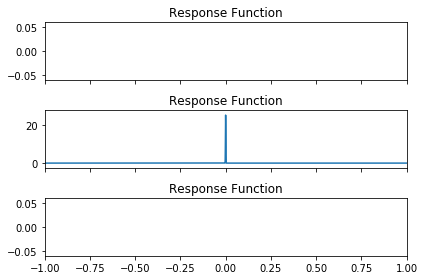

In [51]:
from scipy import special
from scipy import signal
import matplotlib.pyplot as plt
# Testing erfc and getting the gaussian with tail to work 
n_x = 10000



# Function for gaussian with a tail: 
def funcfit(A,l,s,x) : 
    return A* l/2*np.exp(l*x + (l**2*s**2)/2)*special.erfc((x + l*s**2)/(2**.5*s))

# Our original Guassian with a tail. 
def funcfit_test(A,l,s,x) : 
    return A* l/2*np.exp(l*x + (l**2*s**2)/2)*special.erfc((x + l*s**2)/(2**.5*s))
# Our new function, mean about m 
def funcfit_test_b(l,m,s,x) : 
    return l/2*np.exp(l/2*(l*s**2-2*(-x-m)))*special.erfc((l*s**2 - (-x-m))/(2**.5*s))
# a gaussian for comparison
def gaussian( m,s,x) : 
    return 1/(s*(2*np.pi)**2)* np.exp(-.5*((x-m)/s)**2)


# (l/2)*np.exp(l/2(l*s**2-2(x-m)))*
x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers
y = np.linspace(-1, 1, n_x)  # n_x linearly spaced numbers
y_2 = np.zeros(n_x)
y_2[int(n_x/2)] = 1
win4 = y_2
win5 = funcfit_test_b(10**10,0,.001,y)
win6 = gaussian(0,.001,y)
diff = win6-win5

# How to get lambda such that the difference is 10^-6? 


fig, (ax_win4, ax_win5, ax_diff) = plt.subplots(3, 1, sharex=True)

ax_win4.plot(y, win5)
ax_win4.set_title('Response Function')
ax_win4.margins(0, 0.1)
ax_win5.plot(y, win6)
ax_win5.set_title('Response Function')
ax_win5.margins(0, 0.1)
ax_diff.plot(y, diff)
ax_diff.set_title('Response Function')
ax_diff.margins(0, 0.1)
fig.tight_layout()
fig.show()

print(sum(win4))
print(sum(win5))

In [52]:
# Starting with a simpler model. Just a box of width 14ev and a single peak (delta). Looking over this 
# PP by eric machado : https://3.basecamp.com/3700981/buckets/3310561/uploads/2053379840 

from scipy import special
from scipy import signal
import matplotlib.pyplot as plt

# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

e0 = 3.508e6/me + 1  # Helium Endpoint in gamma

# Testing new tail function
n_x = 1000

# Tail with width and normalized height. 

def simple_tail(width,height,n_x) : 
    tail = np.zeros(n_x)
    tail[1] = 1 - height*width
    tail[2:width+2] = height
    return tail   
        
    
  



x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers
y = simple_tail(1,10**-6,n_x)
# print(y)
print(sum(y))

# Math

#bins wide for 

def bin_num(energy,n_x) :  # outputs an integer number of bins associated with an energy width for 6He spectrum
    energy_gamma = energy / me 
    bins = energy_gamma*n_x / (e0-1)
#     return np.around(bins)
    return bins
print(bin_num(1000, 1000))

print(n_x/bin_num(1000, 1000))  # what we would want for n_x to be 1kev bin widths as alejandro has in his


# How to get lambda such that the difference is 10^-6? 


# fig, (ax_win4, ax_win5, ax_diff) = plt.subplots(3, 1, sharex=True)

# ax_win4.plot(y, win5)
# ax_win4.set_title('Response Function')
# ax_win4.margins(0, 0.1)
# ax_win5.plot(y, win6)
# ax_win5.set_title('Response Function')
# ax_win5.margins(0, 0.1)
# ax_diff.plot(y, diff)
# ax_diff.set_title('Response Function')
# ax_diff.margins(0, 0.1)
# fig.tight_layout()
# fig.show()





1.0
0.2850627137970353
3508.0000000000005


In [53]:
x  = np.zeros(5)
x[2:4]= 1
print(x)

[0. 0. 1. 1. 0.]


7.864970645792564
this should be exactly N -> 19999999999.999958


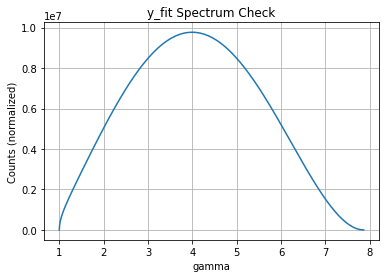

percentage of P that is nan: 0.0


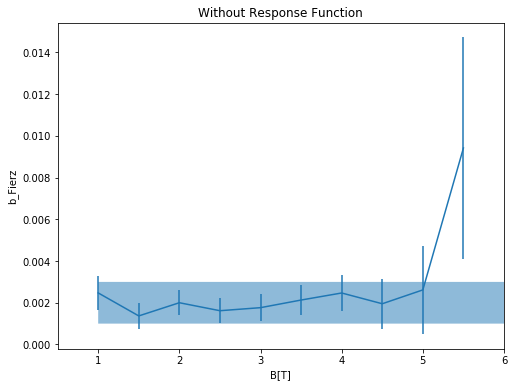

percentage of P that is nan: 0.0


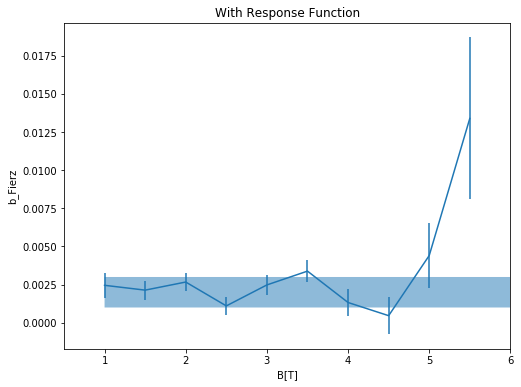

In [25]:
# Now I would like to impliment the convlotion.
# The idea is to effect the spectrum with a response function 'win' and then analyze it as if we didn't 
# know the reponse function and then see what the difference is. 

# Here I am parsing the data by field and redoing Alejandro's Fig. 10 in our proposal.
# Note that NR denotes Numerical Recipes so that you can follow along with the math. 

%matplotlib inline  

from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.pyplot as plt
import math


# -------------------Physical (or natural) Constants -------------------#

me = 5.11e5  # electron mass in eV/c^2
c = 3*10**8
pi= math.pi


# --------------------Input Parameters--------------------#

N = 2e10    # number of counts (simulated).
lil_b = 2e-3 # little b value
n_x = 3508  # number of energy bins in entire spectrum 
n_M = 2    # number of fit parameters 


# -----------------Constructing the Standard (b=0) beta spectrum-------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.
print(e0)

x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit(A,B):
    return A*f_st + B*f_st/x # This function is used to create fake data and to fit. lil_b = B/A. 


# --------------------Normalizing--------------------#

n1_init = 1000   # I use this to create an initital spectrum and then renormalize to get N total counts.  
norm = sum(y_fit(n1_init,lil_b*n1_init))  # norm is the total number of "counts" initially.

C_norm = n1_init*N/norm  # renormalization constant

n1 = C_norm   
n2 = lil_b*C_norm    


print('this should be exactly N ->', sum(y_fit(n1,n2))) # Verifying that the normalization worked. 

# TESTING yfit  to compare to integration method in cell below
fig, ax = plt.subplots()
ax.plot(x, y_fit( n1, n2))
ax.set(xlabel='gamma', ylabel='Counts (normalized)', title='y_fit Spectrum Check')
ax.grid()
plt.show()


# --------------------Including the Convolution / Response Function--------------------#

# Creating the response function. 
frac = 10**-2
win = np.array([frac,1-frac])  # sums to 1. 


def filt(function, window): 
    return signal.convolve( function, window, mode='valid')  / sum(window)  # Should think about why not to use 'full'

filtered = filt(y_fit(n1,n2), win) 

filtered = np.pad(filtered, (0,win.shape[0]-1), 'constant') # The covolution overlap has only n_x - 1 elements since 
# the window is two elements long. So you need to pad the filtered array with some zeros to have it be the 
# same length as the y_fit function. 


# ----------------Setting up the different arrays necessary for the fitting  ------------------------#

n_B = 10 # Sets number of different field strengths we will run with (high by 1) 

P = np.zeros(shape=(n_M,n_B)) # Fit parameters n1, n2 for each field configuration
P_unc = np.zeros(shape=(n_M,n_B)) # Fit uncertainies for each field configuration (NR 15.4.15)
b_fit = np.zeros(shape=(n_B))  # b (from n1, n2) for each field configuration
b_fit_unc = np.zeros(shape=(n_B)) # uncertainty in b for for each field configuration


# --------------------Faking Data --------------------#


y_gdata = np.zeros((2,(y_fit(n1,n2).shape[0])))


y_gdata[0] = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) # Gaussian random data. 

# --------------------Faking Data (with response function 'win') --------------------#

y_gdata[1] = np.around(np.random.normal(filtered, (filtered) ** .5)) # Gaussian random data. 



# --------------------Boundries in Energy for different fields and a fixed 18-24 Ghz bandwidth --------------------#

E_boundries_high = np.zeros(shape=(n_B))  # Upper/Lower bounds in energy for a given B field 
E_boundries_low = np.zeros(shape=(n_B))  

ftoE = c**2/(me*2*pi)  # Note that this is more aptly f to gamma b/c E is measured in units of m_e
B_start = 1 # B field starting at 1 T
B_inc = .5  # B field increased in units of .5 T
f_min = 18e9 # GHz
f_max = 24e9 # GHz


h = 0
while h < n_B:
    E_boundries_high[h] = ftoE*(B_start + h*B_inc)/f_min
    E_boundries_low[h] = ftoE*(B_start + h*B_inc)/f_max  
    h += 1 

    
E_boundries_high_indicies= np.rint((E_boundries_high - 1)*n_x/(e0-1)) # Indicies of the energy bounds
E_boundries_low_indicies= np.rint((E_boundries_low - 1)*n_x/(e0-1))   
# Note that there is overlap in energies between fields especially at higher fields

# There can be energies at these fields and bandwidth beyond our endpoint energy.
# Here I am changing those bounds to just be the last bin of our spectrum. 
g = 0 
while g< n_B: 
    if E_boundries_high_indicies[g] >= n_x:
        E_boundries_high_indicies[g] = n_x-1
    if E_boundries_low_indicies[g] >= n_x:
        E_boundries_low_indicies[g] = n_x-1
    g += 1

# --------------------Doing the fit for both normal and convuluted data. ---------------
ii=0
while ii < 2: 
    
    # --------------------General Linear Least Squares -> n1, n2 -> lil_b (for each field strength) --------------------#

    j = 0 
    while j < n_B: 
        
        # --------------------Parcing up the relevant arrays --------------------#
        x_temp = x[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        f_st_temp = f_st[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        y_gdata_temp = y_gdata[ii][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        n_x_temp = len(x_temp)


        # --------------------Putting together the Toolbox: NR 15.4.1-3--------------------#

        X = np.array([f_st_temp,f_st_temp/x_temp]).transpose() # basis functions. 
        sigma = y_gdata_temp**.5  # Assuming gaussian random data


        # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
        A = np.zeros(shape=(n_x_temp,n_M))

        i=0
        while i < n_M:
            A[:,i] = X[:,i]/sigma
            i += 1

        b_matrix = y_gdata_temp/sigma
        alpha = A.transpose() @ A  #NR 15.5.8
        beta = A.transpose() @ b_matrix   #NR 15.5.9

        P[:,j] = np.linalg.inv(alpha) @ beta



        # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
        i=0
        while i < n_M:
            P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
            i += 1
        b_fit[j] = P[1,j]/P[0,j] # b = n2/n1

        # below is the uncertainty in b using error propigation with a non-zero covariance 
        b_fit_unc[j] = ((P[1,j]/P[0,j])**2 *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2) 
                        - 2*(P[1,j]/P[0,j]**3)*np.linalg.inv(alpha)[0,1])**.5 
        j += 1 


    # --------------------Debugging to see if any of the fits failed --------------------#        

    #This prints the number of nan pairs I get in my P matrix
    print("percentage of P that is nan:",np.argwhere(np.isnan(P)).shape[0]/(2*n_B))


    # --------------------Recreating Alejandro's Fig 10--------------------#   

    B_spect = np.zeros(shape = n_B)  # Array for the x axis of the plot 
    j = 0
    while j < n_B:
        B_spect[j] = B_start + j*B_inc
        j += 1 
    
    if ii == 0: 
        title = 'Without'
    if ii ==1 :
        title = 'With' 
    
    
    pp = PdfPages('{}ResponseFunction2.pdf'.format(title))
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.fill_between(x, .002-10**-3, .002+10**-3, alpha=0.5)
    plt.xlim(.5,6)
    plt.errorbar(B_spect, b_fit, b_fit_unc)
    plt.title("{} Response Function".format(title))    
    plt.ylabel('b_Fierz')
    plt.xlabel('B[T]')
    # plt.xlim([2,7])
    pp.savefig(fig) 
    pp.close()
    plt.show()  
    
    ii += 1

# # -------------------- Plotting n1,n2 (histogram)  --------------------# 

# k = 0
# while k < n_M: 
#     plt.hist(P[k,:]*norm/(n1_init*N), bins=50)
#     plt.ylabel('Frequency')
#     plt.xlabel('Parameter n%d' % k)
#     plt.show()
#     k += 1 





In [26]:
    y = [[2,2,3],[1,1,4]]
    print(y[0][0:2])
    

[2, 2]


In [27]:
from IPython.display import Math
Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx')



<IPython.core.display.Math object>

In [28]:
$$ HR $$


SyntaxError: invalid syntax (<ipython-input-28-9a9789f59795>, line 1)

In [29]:
# figuring out numeric integration because I will need that for the next step. 

import scipy.integrate as integrate
import scipy.special as special


def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.


print( integrate.quad(lambda x: spect_data(x,e0), 1, 1.1)) 
print(spect_data(1.05,e0))


# Of course these two are not the same, but should create the same spectrum... Need to put some work into this. 

(1.4851246630934491, 5.043876427635041e-11)
15.612742998067866


this should be exactly N -> 20000000000.00005
(3.9610758229866683, 7.108328752003512e-10)
(0.455206411917955, 1.6353959210423232e-09)
erfc_step 0.0
percentage of P that is nan: 0.0


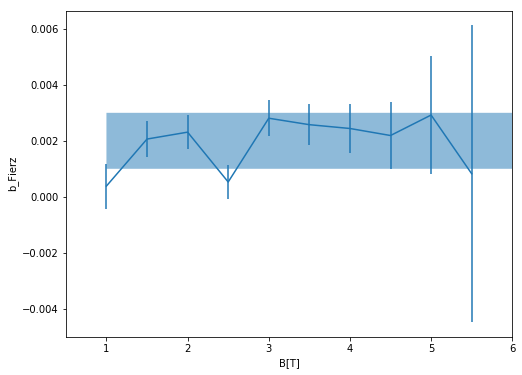

percentage of P that is nan: 0.0


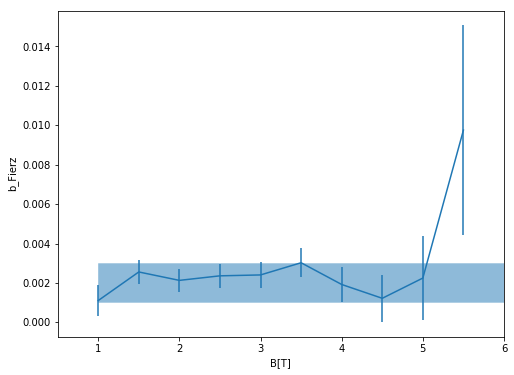

In [30]:
# This script creates the spectrum by integrating the differential decay rate and looks at the effect of
# adding in an erfc with N_erfc = frac*N (frac = 10**-6 we think) centered at .5 MeV. The slope of the erfc 
# should also be explored. 

%matplotlib inline  

import scipy.integrate as integrate
import scipy.special as special
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.pyplot as plt
import math


# -------------------Physical (or natural) Constants -------------------#

me = 5.11e5  # electron mass in eV/c^2
c = 3*10**8
pi= math.pi


# --------------------Input Parameters--------------------#

N = 2e10    # number of counts (simulated).
lil_b = 2e-3 # little b value
n_x = 3508  # number of energy bins in entire spectrum (3508 = 1keV bin width)
n_M = 2    # number of fit parameters 


# -----------------Constructing the Standard (b=0) beta spectrum-------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.


x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit_pre(A,B,x):  # little b effected spectrum.
    return A*spect_data(x, e0) + B*spect_data(x, e0)/x # This function is used to create fake data and to fit. lil_b = B/A. 

# --------------------Creating the discrete spectrum via integrating the differential decay rate--------------------#

n1_init = 10000   # I use this to create an initital spectrum and then renormalize to get N total counts.  
# Note: My results are (as expected) independent of the value of this parameter. 

delta = (e0 - 1)/n_x  # The distance between bin edges in terms of gamma. 

def g(A,B,e_prime):         # My integration over the differential decay spectrum
    g = integrate.quad(lambda z: y_fit_pre(A, B,z), e_prime, e_prime+delta)
    return g

def y_fit(A,B):
    y_fit = np.zeros(n_x)
    
    for i, a in enumerate(x):
        y_fit[i] = g(A,B,a)[0]
    
    return y_fit

# --------------------Creating basis functions for the fit--------------------#

def g_1(e_prime):         # My integration over the differential decay spectrum
    g_1 = integrate.quad(lambda z: spect_data(z, e0), e_prime, e_prime+delta)
    return g_1

def g_2(e_prime):         # My integration over the differential decay spectrum
    g_2 = integrate.quad(lambda z: spect_data(z, e0)/z, e_prime, e_prime+delta)
    return g_2

basis = np.zeros((2,n_x))
    
for i, a in enumerate(x):
    basis[0][i] = g_1(a)[0]
    basis[1][i] = g_2(a)[0]
    
# --------------------Normalizing to N total "counts". Note: Different now with integration method 11/20/19--------------------#

norm = sum(y_fit(n1_init,lil_b*n1_init))  # norm is the total number of "counts" initially.

C_norm = n1_init*N/norm  # renormalization constant

n1 = C_norm   
n2 = lil_b*C_norm    


print('this should be exactly N ->', sum(y_fit(n1,n2))) # Verifying that the normalization worked. 

# # TESTING yfit normalized 
# fig, ax = plt.subplots()
# ax.plot(x, y_fit( n1,n2))
# ax.set(xlabel='gamma', ylabel='Counts (normalized)', title='y_fit Spectrum Check')
# ax.grid()
# plt.show()


# --------------------Including the <.5 MeV ERFC --------------------#

endpoint_eV = 3.508e6
step_eV = .5e6  # This is where the step should end (middle of erfc sits here)
frac = 0

A_scatt = integrate.quad(lambda z: special.erfc(5*z- step_eV*e0/endpoint_eV), 0, 100 )

def f_scatt(z):
    return special.erfc(z-( 1+.5*(7.86-1)/3.5))


print(integrate.quad(lambda z: f_scatt(z), 0, 1000 ))
A = sum(f_scatt(x))

erfc_step = frac*N/A*f_scatt(x)
print(A_scatt)

filtered = y_fit(n1,n2) + erfc_step
print( 'erfc_step', sum(erfc_step)/N)

# TESTING the addition of the step to the spectrum

# pp = PdfPages('ERFCplot_1.pdf')

# fig, ax = plt.subplots()
# ax.plot(x, filtered, label="Combined")
# ax.plot(x, erfc_step, label="Step @ .5 MeV")
# ax.plot(x, y_fit(n1,n2), label = "Standard")
# ax.set(xlabel='gamma', ylabel='Counts', title='Step @ .5 Mev, 10% Effect')
# ax.legend()
# ax.grid()
# plt.show()

# pp.savefig(fig) 
# pp.close()
# plt.show() 

# ----------------Setting up the different arrays necessary for the fitting  ------------------------#

n_B = 10 # (n_B -1) Sets number of different field strengths we will run with  

P = np.zeros(shape=(n_M,n_B)) # Fit parameters n1, n2 for each field configuration
P_unc = np.zeros(shape=(n_M,n_B)) # Fit uncertainies for each field configuration (NR 15.4.15)
b_fit = np.zeros(shape=(n_B))  # b (from n1, n2) for each field configuration
b_fit_unc = np.zeros(shape=(n_B)) # uncertainty in b for for each field configuration


# --------------------Faking Data --------------------#


y_gdata = np.zeros((2,(y_fit(n1,n2).shape[0])))


y_gdata[0] = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) # Gaussian random data. 

# --------------------Faking Data (with response function 'win') --------------------#

y_gdata[1] = np.around(np.random.normal(filtered, (filtered) ** .5)) # Gaussian random data. 



# --------------------Boundries in Energy for different fields and a fixed 18-24 Ghz bandwidth --------------------#

E_boundries_high = np.zeros(shape=(n_B))  # Upper/Lower bounds in energy for a given B field 
E_boundries_low = np.zeros(shape=(n_B))  

ftoE = c**2/(me*2*pi)  # Note that this is more aptly f to gamma b/c E is measured in units of m_e
B_start = 1 # B field starting at 1 T
B_inc = .5  # B field increased in units of .5 T
f_min = 18e9 # GHz
f_max = 24e9 # GHz


h = 0
while h < n_B:
    E_boundries_high[h] = ftoE*(B_start + h*B_inc)/f_min
    E_boundries_low[h] = ftoE*(B_start + h*B_inc)/f_max  
    h += 1 

    
E_boundries_high_indicies= np.rint((E_boundries_high - 1)*n_x/(e0-1)) # Indicies of the energy bounds
E_boundries_low_indicies= np.rint((E_boundries_low - 1)*n_x/(e0-1))   
# Note that there is overlap in energies between fields especially at higher fields

# There can be energies at these fields and bandwidth beyond our endpoint energy.
# Here I am changing those bounds to just be the last bin of our spectrum. 
g = 0 
while g< n_B: 
    if E_boundries_high_indicies[g] >= n_x:
        E_boundries_high_indicies[g] = n_x-1
    if E_boundries_low_indicies[g] >= n_x:
        E_boundries_low_indicies[g] = n_x-1
    g += 1

# --------------------Doing the fit for both normal and erfc effected data. ---------------
ii=0
while ii < 2: 
    
    # --------------------General Linear Least Squares -> n1, n2 -> lil_b (for each field strength) --------------------#

    j = 0 
    while j < n_B: 
        
        # --------------------Parcing up the relevant arrays --------------------#
        x_temp = x[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        f_st_temp = f_st[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        y_gdata_temp = y_gdata[ii][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        n_x_temp = len(x_temp)
            
        # Parcing up new basis element
        
        basis_temp_0 = basis[0][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        basis_temp_1 = basis[1][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        
        # --------------------Putting together the Toolbox: NR 15.4.1-3--------------------#

#         X = np.array([f_st_temp,f_st_temp/x_temp]).transpose() # basis functions. 
        X = np.array([basis_temp_0,basis_temp_1]).transpose()                      # basis functions.
        sigma = y_gdata_temp**.5  # Assuming gaussian random data


        # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
        A = np.zeros(shape=(n_x_temp,n_M))

        i=0
        while i < n_M:
            A[:,i] = X[:,i]/sigma
            i += 1

        b_matrix = y_gdata_temp/sigma
        alpha = A.transpose() @ A  #NR 15.5.8
        beta = A.transpose() @ b_matrix   #NR 15.5.9

        P[:,j] = np.linalg.inv(alpha) @ beta



        # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
        i=0
        while i < n_M:
            P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
            i += 1
        b_fit[j] = P[1,j]/(P[0,j]) # b = n2/n1
        
        # below is the uncertainty in b using error propigation with a non-zero covariance 
        b_fit_unc[j] = ((P[1,j]/P[0,j])**2 *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2) 
                        - 2*(P[1,j]/P[0,j]**3)*np.linalg.inv(alpha)[0,1])**.5 
        j += 1 


    # --------------------Debugging to see if any of the fits failed --------------------#        

    #This prints the number of nan pairs I get in my P matrix
    print("percentage of P that is nan:",np.argwhere(np.isnan(P)).shape[0]/(2*n_B))


    # --------------------Recreating Alejandro's Fig 10--------------------#   

    B_spect = np.zeros(shape = n_B)  # Array for the x axis of the plot 
    j = 0
    while j < n_B:
        B_spect[j] = B_start + j*B_inc
        j += 1 
    
    if ii == 0: 
        title = 'Without'
    if ii ==1 :
        title = 'With' 
    
    
    pp = PdfPages('Fig10Recreated.pdf'.format(100*frac))
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.fill_between(x, .002-10**-3, .002+10**-3, alpha=0.5)
    plt.xlim(.5,6)
    plt.errorbar(B_spect, b_fit, b_fit_unc)
#     plt.title("".format(frac))    
    plt.ylabel('b_Fierz')
    plt.xlabel('B[T]')
    # plt.xlim([2,7])
    pp.savefig(fig) 
    pp.close()
    plt.show()  
    
    ii += 1




In [31]:
# Figuring out the erfc step caused by the electrons colliding with the kapton (cross section = 0 @ >.5MeV)
# And also figuring out how to do a continuos convolution. 
from scipy import special
import matplotlib.pyplot as plt
x = np.linspace(-3, 3)



# def convolution(f(z),g(z)):  
#     conv = 
    
print(integrate.quad(lambda x: f(z)g(x-z), -1000, 1000 ))



plt.plot(x, special.erfc(x- .5*7.86/3.5))
plt.xlabel('$x$')
plt.ylabel('$erfc(x)$')
plt.show()

SyntaxError: invalid syntax (<ipython-input-31-d5a11e42ed39>, line 12)

this should be exactly N -> 19999999999.99992


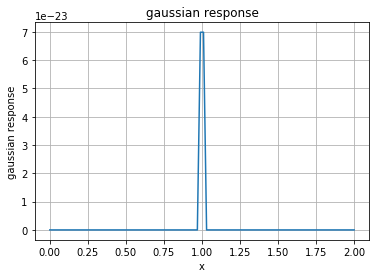

filt normalization: This should be N -> 19999999999.999958


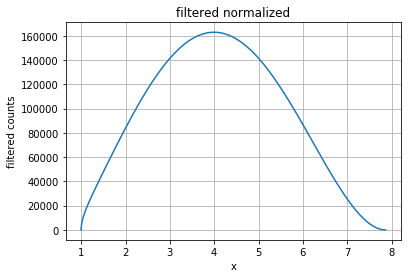

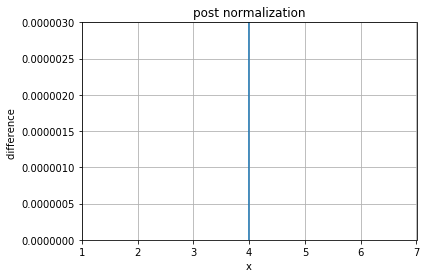

percentage of P that is nan: 0.0


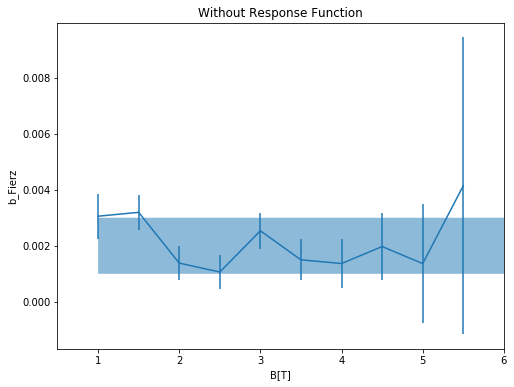

percentage of P that is nan: 0.0


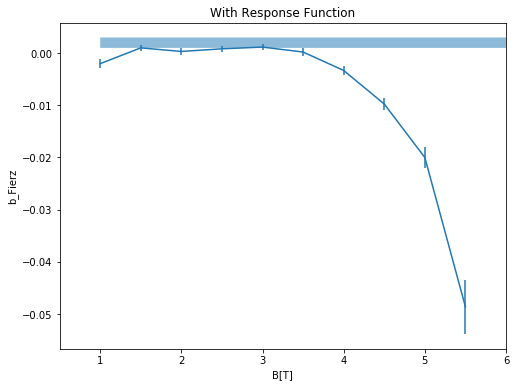

In [76]:
# Here I will do the convolution of the differential decay rate with a general response function before 
# integrating to get the counts in each bin. This will be done by breaking the bins into pieces to do the
# Convolution numerically. Then I can explore the effect of different response 
# functions (like eric's)

%matplotlib inline  

from scipy import signal
import scipy.integrate as integrate
import scipy.special as special
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.pyplot as plt
import math


# -------------------Physical (or natural) Constants -------------------#

me = 5.11e5  # electron mass in eV/c^2
c = 3*10**8
pi= math.pi


# --------------------Input Parameters--------------------#

N = 2e10    # number of counts (simulated).
lil_b = 2e-3 # little b value
n_x = 3508  # number of energy bins in entire spectrum (3508 = 1keV bin width)
n_subbins = 60       # This is the number of subbins in each of the n_x bins we will have. 
n_M = 2    # number of fit parameters 


# -----------------Constructing the Standard (b=0) beta spectrum-------------------------#

def spect_data(e, e0):   # The undistorted spectrum as a function of the energy and endpoint energy (e0)
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.

x = np.linspace(1, e0, n_x)  # n_x linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit_pre(A,B,x):  # little b effected spectrum.
    return A*spect_data(x, e0) + B*spect_data(x, e0)/x # This function is used to create fake data and to fit. lil_b = B/A. 

# --------------------Creating the discrete spectrum via integrating the differential decay rate--------------------#

n1_init = 1000   # I use this to create an initital spectrum and then renormalize to get N total counts.  
# Note: My results are (as expected) independent of the value of this parameter. 

delta = (e0 - 1)/n_x  # The distance between bin edges in terms of gamma. 

x_conv = np.linspace(1, e0, n_x*n_subbins)  # n_x*n_subbins linearly spaced numbers

def y_fit(A,B):   # Having this match the way we get the convolved spectrum 
    y_fit = np.zeros(n_x)
    y_fit_subbins = y_fit_pre(A,B,x_conv)
    
    for i, a in enumerate(x):
        y_fit[i] = np.sum(y_fit_subbins[i*n_subbins: (i+1)*n_subbins])
    
    return y_fit

# --------------------Creating basis functions for the fit--------------------#

basis_1 = spect_data(x_conv,e0)
basis_2 = spect_data(x_conv,e0)/x_conv


basis = np.zeros((2,n_x))
    
for i, a in enumerate(x):
    basis[0][i] = np.sum(basis_1[i*n_subbins: (i+1)*n_subbins])
    basis[1][i] = np.sum(basis_2[i*n_subbins: (i+1)*n_subbins])
    
# --------------------Normalizing to N total "counts".--------------------#

norm = sum(y_fit(n1_init,lil_b*n1_init))  # norm is the total number of "counts" initially.

C_norm = n1_init*N/norm  # renormalization constant

n1 = C_norm   
n2 = lil_b*C_norm    


print('this should be exactly N ->', sum(y_fit(n1,n2))) # Verifying that the normalization worked. 


# --------------------Convoluting the spectrum with a response function. And Normalizing--------------------#
# Here I am breaking the differential decay rate into n_x*n_subbins bins so that I can convolve it then sum 
# up the blocks into n_x (# number of energy bins) bins. Then I renormalize that spectrum. 
 
def y_fit_conv(A,B):
    y_fit_conv = np.zeros(n_x*n_subbins)
    
    for i, a in enumerate(x_conv):
        y_fit_conv[i] = y_fit_pre(A,B,a)
    return y_fit_conv


# Creating the response function. 

response_func_0 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])  # Doesn't need to be normalized.  
response_func_1 = np.array([0,1])  # Doesn't need to be normalized.  
response_func_2 = np.array([1])
# Debugging with a guassian response function 
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x_values = np.linspace(0, 2, 100)

gaussian_response = gaussian(x_values, 1, .001 )    
testplot(x_values, gaussian_response, 'x', 'gaussian response','gaussian response',0,0)    
# A function that discretely convolves two disctrete functions and then pads the result to match the length of the function. 

def filt(function, response_function): 
    filt = signal.convolve( function, response_function, mode='same') 
#     filt = np.pad(filt, (0,response_function.shape[0]-1), 'constant') 
    return filt

filtered_conv = filt(y_fit_conv(n1,n2), response_func_0) # "filtered" refering to the fact it has now been effected by the response function

filtered = np.zeros(n_x)

i = 0
while i < n_x:  # Summing up the subbins to get a filtered spectum with n_x bins/elements
    filtered[i] = np.sum(filtered_conv[i*n_subbins: (i+1)*n_subbins])
    i += 1
    
# --------------------Normalizing  the convolved spectrum to N total "counts". Note: Different now with integration method 11/20/19--------------------#

norm = sum(filtered)  # norm is the total number of "counts" initially.
filtered = N/norm* filtered  # renormalization constant
print('filt normalization: This should be N ->', sum(filtered)) # Check to see if filtered was properly normalized

testplot(x_conv, filtered_conv, 'x','filtered counts', 'filtered normalized',0,0) # TESTING filtered (normalized) 

testplot(x, filtered-y_fit(n1,n2), 'x','difference ', 'post normalization',(1,7),(0,.000003)) # TESTING filtered (normalized) 

# ----------------BEGIN FITTING: Setting up the different arrays necessary for the fitting  ------------------------#

n_B = 10 # (n_B -1) Sets number of different field strengths we will run with  

P = np.zeros(shape=(n_M,n_B)) # Fit parameters n1, n2 for each field configuration
P_unc = np.zeros(shape=(n_M,n_B)) # Fit uncertainies for each field configuration (NR 15.4.15)
b_fit = np.zeros(shape=(n_B))  # b (from n1, n2) for each field configuration
b_fit_unc = np.zeros(shape=(n_B)) # uncertainty in b for for each field configuration


# --------------------Faking Data --------------------#

y_gdata = np.zeros((2,(y_fit(n1,n2).shape[0])))

y_gdata[0] = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) # Gaussian random data. 

# --------------------Faking Data (with response function 'win') --------------------#

y_gdata[1] = np.around(np.random.normal(filtered, (filtered) ** .5)) # Gaussian random data. 

# --------------------Boundries in Energy for different fields and a fixed 18-24 Ghz bandwidth --------------------#

E_boundries_high = np.zeros(shape=(n_B))  # Upper/Lower bounds in energy for a given B field 
E_boundries_low = np.zeros(shape=(n_B))  

ftoE = c**2/(me*2*pi)  # Note that this is more aptly f to gamma b/c E is measured in units of m_e
B_start = 1 # B field starting at 1 T
B_inc = .5  # B field increased in units of .5 T
f_min = 18e9 # GHz
f_max = 24e9 # GHz

h = 0
while h < n_B:
    E_boundries_high[h] = ftoE*(B_start + h*B_inc)/f_min
    E_boundries_low[h] = ftoE*(B_start + h*B_inc)/f_max  
    h += 1 
 
E_boundries_high_indicies= np.rint((E_boundries_high - 1)*n_x/(e0-1)) # Indicies of the energy bounds
E_boundries_low_indicies= np.rint((E_boundries_low - 1)*n_x/(e0-1))   
# Note that there is overlap in energies between fields especially at higher fields

# There can be energies at these fields and bandwidth beyond our endpoint energy.
# Here I am changing those bounds to just be the last bin of our spectrum. 
g = 0 
while g< n_B: 
    if E_boundries_high_indicies[g] >= n_x:
        E_boundries_high_indicies[g] = n_x-1
    if E_boundries_low_indicies[g] >= n_x:
        E_boundries_low_indicies[g] = n_x-1
    g += 1

# --------------------Doing the fit for both normal and erfc effected data. ---------------
ii=0
while ii < 2: 
    
    # --------------------General Linear Least Squares -> n1, n2 -> lil_b (for each field strength) --------------------#

    j = 0 
    while j < n_B: 
        
        # --------------------Parcing up the relevant arrays --------------------#
        x_temp = x[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        f_st_temp = f_st[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        y_gdata_temp = y_gdata[ii][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        n_x_temp = len(x_temp)
            
        # Parcing up new basis element
        
        basis_temp_0 = basis[0][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        basis_temp_1 = basis[1][int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
        
        # --------------------Putting together the Toolbox: NR 15.4.1-3--------------------#

        X = np.array([basis_temp_0,basis_temp_1]).transpose()                      # basis functions.
        sigma = y_gdata_temp**.5  # Assuming gaussian random data


        # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
        A = np.zeros(shape=(n_x_temp,n_M))

        i=0
        while i < n_M:
            A[:,i] = X[:,i]/sigma
            i += 1

        b_matrix = y_gdata_temp/sigma
        alpha = A.transpose() @ A  #NR 15.5.8
        beta = A.transpose() @ b_matrix   #NR 15.5.9

        P[:,j] = np.linalg.inv(alpha) @ beta



        # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
        i=0
        while i < n_M:
            P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
            i += 1
        b_fit[j] = P[1,j]/(P[0,j]) # b = n2/n1
        
        # below is the uncertainty in b using error propigation with a non-zero covariance 
        b_fit_unc[j] = ((P[1,j]/P[0,j])**2 *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2) 
                        - 2*(P[1,j]/P[0,j]**3)*np.linalg.inv(alpha)[0,1])**.5 
        j += 1 


    # --------------------Debugging to see if any of the fits failed --------------------#        

    #This prints the number of nan pairs I get in my P matrix
    print("percentage of P that is nan:",np.argwhere(np.isnan(P)).shape[0]/(2*n_B))


    # --------------------Recreating Alejandro's Fig 10--------------------#   

    B_spect = np.zeros(shape = n_B)  # Array for the x axis of the plot 
    j = 0
    while j < n_B:
        B_spect[j] = B_start + j*B_inc
        j += 1 
    
    if ii == 0: 
        title = 'Without'
    if ii ==1 :
        title = 'With' 
    
    
    pp = PdfPages('{}ResponseFunction2.pdf'.format(title))
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.fill_between(x, .002-10**-3, .002+10**-3, alpha=0.5)
    plt.xlim(.5,6)
    plt.errorbar(B_spect, b_fit, b_fit_unc)
    plt.title("{} Response Function".format(title))    
    plt.ylabel('b_Fierz')
    plt.xlabel('B[T]')
    # plt.xlim([2,7])
    pp.savefig(fig) 
    pp.close()
    plt.show()  
    
    ii += 1




In [ ]:
# Testing the convolution function and the different modes to see what I need to use? 

def filt(function, response_function): 
    filt = signal.convolve( function, response_function, mode='same') 
#     filt = np.pad(filt, (0,response_function.shape[0]-1), 'constant') 
    return filt



x_conv = np.linspace(0, e0, n_x*n_subbins)
# Debugging with a guassian response function 
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))